# Modelling count data with Tensorflow Probability

**Goal:** In this notebook you will work with TFP. You will set up regression models that are able to output different conditional probability distributions to model count data. You will define different models with Keras and the Tensorflow probability framework and optimize the negative log likelihood (NLL). 

**You should here focus on the Poisson regression which is the easiest model that is appropriate for count data.**

Finally, we demonstrate how to extent the Poisson model to the zero-inflated Poisson model. 

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it.

**Dataset:** You work with a camper dataset form https://stats.idre.ucla.edu/r/dae/zip/. The dataset contains data on 250 groups that went to a park. Each group was questioned about how many fish they caught (count), how many children were in the group (child), how many people were in the group (persons), if they used a live bait and whether or not they brought a camper to the park (camper). You split the data into train and test dataset.

**Content:**

* Work with different distributions in TFP: Poisson and zero-inflated Poisson

* Load and split the camper dataset

* Fit different regression models to the camper train dataset:Poisson regression and zero-inflated Poisson regression

* Plot the predicted probability distributions (CPD) for two specific datapoints along with their likelihood

* Plot the testdata along with the predicted mean and the 2.5% and 97.5% percentiles of the predicted CPD

* Compare the different models based on the test NLL


This Rmarkdown report is based on this [dl_book jupyter notebook](https://github.com/tensorchiefs/dl_book/blob/master/chapter_05/nb_ch05_02.ipynb) 

# Installing TensorFlow and Keras

The deep learning packages, TensorFlow and Keras are not installed by default, but can be installed as follows:

In [1]:
COLAB = FALSE
KAGGLE = TRUE

Installing TFP (see https://www.kaggle.com/code/oduerr/tfp-with-r) in case you have problem. The code worked Sep 2022, but it might not work in the future.

In [2]:
#Installing TF and Keras takes approx 2 minutes
if (COLAB){
    #Installing TF and Keras takes approx 2 minutes
    ptm <- proc.time()
    install.packages("tensorflow")
    install.packages("keras")
    install.packages("tfprobability") #needs approx 30 seconds
    install.packages("RCurl")
    install.packages("kableExtra")
    install.packages("reshape2")
    install.packages("cowplot")
    install.packages("kableExtra")
    proc.time() - ptm
    #devtools::install_github("rstudio/keras") works ok but no tfp
}
if (KAGGLE){
   reticulate::use_condaenv("r-reticulate", required = TRUE) #We activate the conda enviroment
   reticulate::py_install('tensorflow_probability==0.14.1', pip=TRUE, envname="r-reticulate") #Installs the correct python version of TFP
   install.packages("tfprobability") #This installs the R-wrappers of TFP
}

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# Imports

In the next cell, we load all the required libraries and functions. 

In [3]:
#devtools::install_github("rstudio/keras") works ok but no tfp
library(tidyverse)
require(graphics)
library(kableExtra)
library(cowplot)
library(reshape2)

library(keras)
library(tensorflow)
library(tfprobability)
tf$version$VERSION #2.3.0
tf$test$gpu_device_name() #If '/device:GPU:0' you are on a GPU. You don't need a GPU for this example

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loaded Tensorflow version 2.6.5



[1] "2.6.5"

[1] ""

# Working with a TFP Poisson distribution

Here you can see a small example how to work with a Poisson distribution in TFP. The Poisson distribution has only one parameter, often called $\lambda$ or rate, which defines the mean and the variance of the distribution. We set the rate $\lambda$ to 2, and plot the probability distribution for the values 0 to 10. Below in the notebook you will define a model to learn this parameter.

**Listing 5.5: The Poisson Distribution in TFP**

In [4]:
# Poisson distribution with parameter rate = 2:
dist = tfd_poisson(rate=2)
# Integer values from 0 to 10 for the x-axis
vals = seq(0, 10, len=11)
# Probability for the values:
p = dist$prob(vals)$numpy()
print(dist$mean()$numpy())  #The mean value yielding 2.0
print(dist$stddev()$numpy())   #The standard deviation yielding sqrt(2.0) = 1.41...

[1] 2
[1] 1.414214


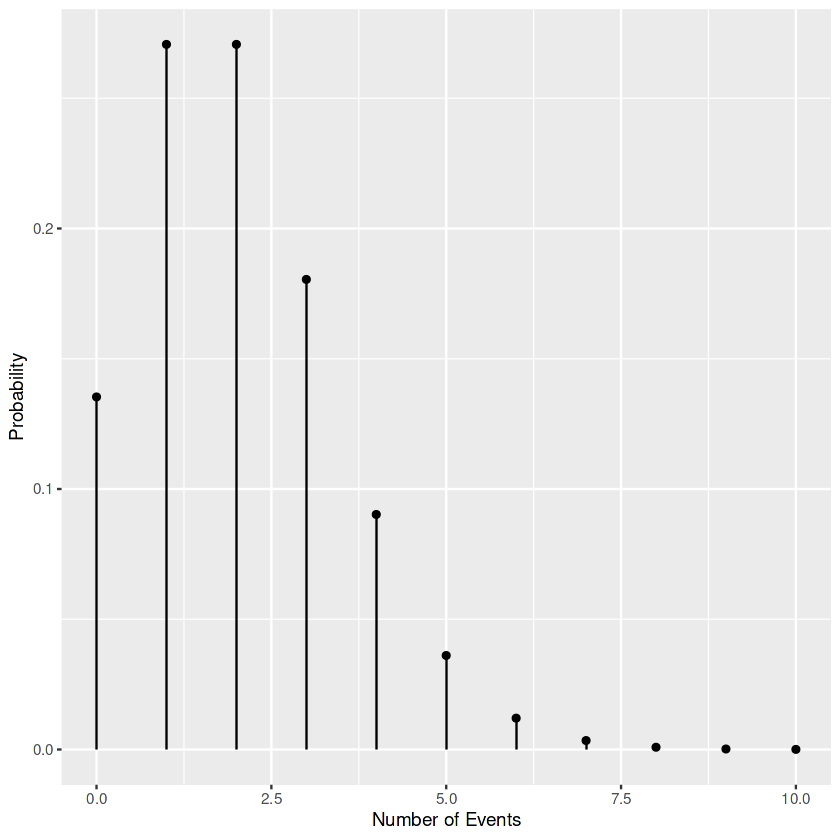

In [5]:
df = data.frame(vals, p)
ggplot(df, aes(x=vals, y=p, xend=vals, yend=0)) + 
  geom_point() +
  geom_segment() + xlab("Number of Events") + ylab("Probability")

# Loading real count data

Here you load the camper data from: https://stats.idre.ucla.edu/r/dae/zip/. The target variable is the number of fish caught, during a state park visit by a group. You have data of 250 groups that went to the park. Each group was questioned about how many fish they caught (count), how many children were in the group (child), how many people were in the group (persons), if they used a live bait (livebait) and whether or not they brought a camper to the park (camper). This will be the features. You randomly split the data into train and test dataset (80% train and 20% test).


In [6]:
# The Fish Data Set
# See example 2 from https://stats.idre.ucla.edu/r/dae/zip/ 
#"nofish","livebait","camper","persons","child","xb","zg","count"
s_url = "https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/fish.csv"
dat = read.table(s_url, sep=',', head=T)
X = dat[, 2:5] #"livebait","camper","persons","child
y = dat[, 8]

# Uncomment the next lines, to enhance the ZIP model (for later)
# (see below why you would like to do it)

# n = length(y)
# idx = sample(n)[seq_len(floor(n*0.3))] 
# y[idx] = 0

Let's split the data and look at the counts (how many fish each group caught).


In [7]:
train_test_split = function(X, y, test_size=0.2, random_state=42, shuffle=TRUE){
  set.seed(random_state)
  n = length(y)
  test_size = floor(test_size * n)
  train_size = n - test_size
  train <- sample(seq_len(n), train_size)
  X_train <- X[train, ]
  X_test <- X[-train, ]
  y_train <- y[train]
  y_test <- y[-train]
  return(list(X_train, X_test, y_train, y_test))
}

In [8]:
c(X_train, X_test, 
  y_train, y_test) %<-% train_test_split(X, y, test_size=0.2,
                                         random_state=42, shuffle=TRUE)
y_train = as.double(y_train)
y_test = as.double(y_test)
X_train = apply(X_train, 2, as.double)
X_test = apply(X_test, 2, as.double)
X_train = as.matrix(X_train)
X_test = as.matrix(X_test)

dim(X_train)
length(y_train)
dim(X_test)
length(y_test)
dim(dat)

[1] 200   4

[1] 200

[1] 50  4

[1] 50

[1] 250   8

In the following we will look at the number of fish each group caught.

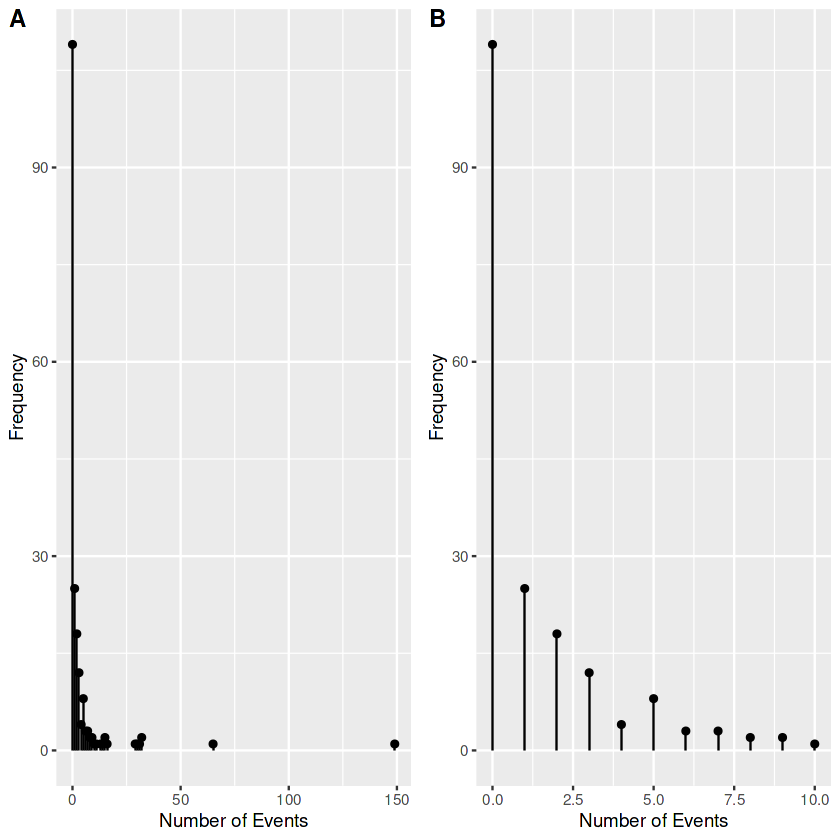

In [9]:
df = as.data.frame(table(y_train))
df$y_train = as.numeric(as.character(df$y_train))
thisplot = function(xrange){
  ggplot(df, aes(x=y_train, y=Freq, xend=y_train, yend=0)) + 
  geom_point() +
  geom_segment() + 
  coord_cartesian(xlim = xrange) +
  xlab("Number of Events") + ylab("Frequency")
}
plot_grid(thisplot(range(df$y_train)), thisplot(c(0,10)), labels = "AUTO")

You see that most of the groups didn't catch any fish at all. Most of the groups were not very successful, but there is one group that was very successful and caught 149 fish!

Lets pick the two test observations 31 and 33, which you will investigate in the following.

# Poisson Regression

Now you use the TFP framework and the Poission distribution to model the output of the network as a Poissonian CPD. You will not use any hidden layers in between and the loss will be the NLL. After the fitting, you predict the test data and compare the performance with the linear regression model.

${\mathbf Y} \thicksim Pois(\exp(w^Tx+b))$


**Question**: Use the following plot to read the likelihood of the observation number of fish count=4.



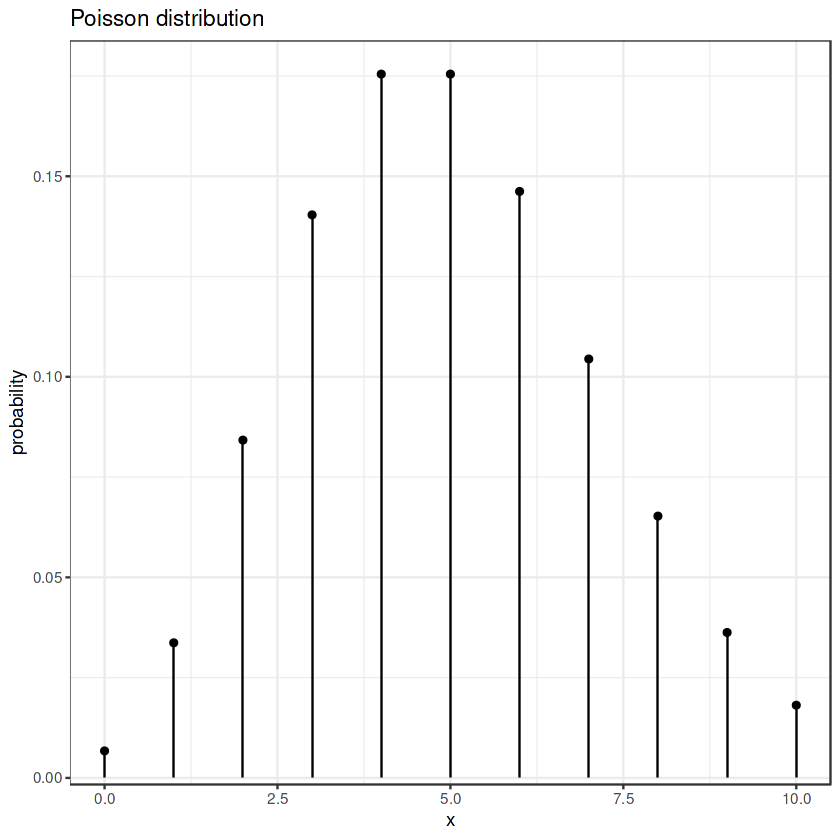

In [10]:
dp <- tfd_poisson(rate = 5)
ppx <- tfd_prob(dp,seq(0,10,by=1))

data.frame(x=seq(0,10,by=1),probability=as.numeric(ppx)) %>%
  ggplot(aes(x=x,y=probability)) +
  geom_point() +
  geom_linerange(aes(ymax=probability), ymin=0) + 
  ggtitle("Poisson distribution") +
  theme_bw()

.

.

.

.

**Answer:** From the plot we can see that the likelihood for a count of 4 is ~0.175

**Question** Use TFP to determine the likelihood or log-likelihood of observed count=4 values under a Poisson model with rate 5.

.

.


.

.

.

.

In [11]:
dp <- tfd_poisson(rate = 5)  # poisson distribution with rate 5

l5 <- tfd_prob(dp,4)  # likelihood of count=4 under this distribution
l5
log(l5)  # log likelihood

tfd_log_prob(dp, 4)  # log likelihood with specific tfp function

tf.Tensor(0.17546739, shape=(), dtype=float32)

tf.Tensor(-1.7403021, shape=(), dtype=float32)

tf.Tensor(-1.7403021, shape=(), dtype=float32)

Let's build a NN to model the counts of caught fish.

In [12]:
model_p = keras_model_sequential() %>%
     layer_dense(units=1L, activation=tfb_exp()) %>%
     layer_distribution_lambda(tfd_poisson)


model_p(as.matrix(X_train[1:3,])) #Returns distribution
model_p(as.matrix(X_train[1:3,]))$mean() #Returns mean value of distribution

<tfp.distributions._TensorCoercible 'sequential_distribution_lambda_tensor_coercible' batch_shape=[3, 1] event_shape=[] dtype=float32>

tf.Tensor(
[[ 22.805094]
 [ 88.77088 ]
 [316.30643 ]], shape=(3, 1), dtype=float32)

**Question:** Why do we use an exponential function as activation to determine the rate of a Poisson model? 

Adding loss

In [13]:
NLL = function(y_true, dist) -tfd_log_prob(dist, y_true)
model_p = compile(model_p, optimizer=optimizer_adam(lr = 0.01), loss=NLL)
summary(model_p)

Warning message in backcompat_fix_rename_lr_to_learning_rate(...):
“the `lr` argument has been renamed to `learning_rate`.”


Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense (Dense)                       (3, 1)                          5           
________________________________________________________________________________
distribution_lambda (DistributionLa multiple                        0           
Total params: 5
Trainable params: 5
Non-trainable params: 0
________________________________________________________________________________


Let's train the model.

In [14]:
hist_p = fit(model_p, x=X_train, y=y_train, batch_size=length(y_train),
             epochs=500, verbose=0, validation_data=list(X_test, y_test))

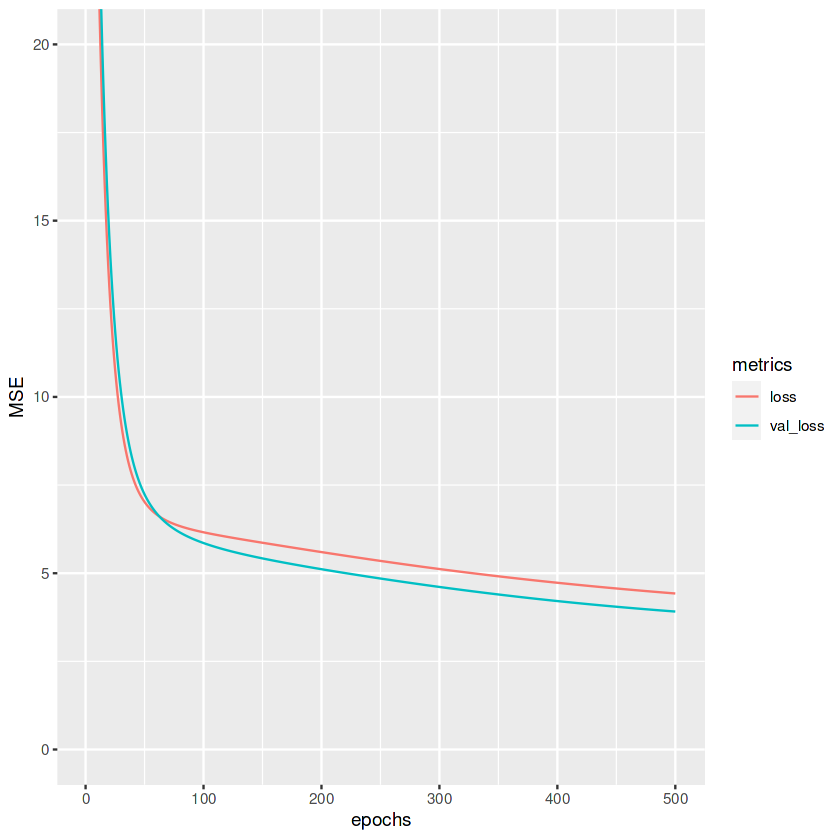

In [15]:
df = as.data.frame(hist_p$metrics)
df$epochs = seq_len(nrow(df))
df = melt(df, id.vars = "epochs", variable.name = "metrics", value.name = "MSE")
ggplot(df, aes(x=epochs, y=MSE, color=metrics)) + geom_line() +
  coord_cartesian(ylim=c(0,20))

**Answer**: The exponentional function is used as activation because the rate (=expected value of the number of counts, in statstics often called lambda) has to be a non-negative number which is achieved by a exp-transformation. 

## Evaluation of the Performance

In [16]:
evaluate(model_p, X_test, y_test) 
y_hat_test = as.numeric(   # Tensor --> Real Values
    model_p(X_test)$mean() # model_p(X_test) is a Distribution and the mean value would be point prediction
)

loss 
3.912883

In [17]:
#Prediction on the testset
#model = keras_model(inputs=inputs, outputs=p_y$mean())
#y_hat_test = predict_on_batch(model, X_test)
str(y_hat_test) 
RMSE = sqrt(mean((y_test - y_hat_test)^2))
MAE = mean(abs(y_test- y_hat_test)) 
NLL_p = evaluate(model_p, X_test, y_test) 
df3 = data.frame(RMSE=RMSE, 
                 MAE=MAE, 
                 'NLL (mean)'= NLL_p, check.names = F)
rownames(df3) = "Poisson Regression (TFP)"
kable(rbind(df3), format = "simple")

 num [1:50] 3.14 5.62 2.4 2.32 5.62 ...




                                RMSE        MAE   NLL (mean)
-------------------------  ---------  ---------  -----------
Poisson Regression (TFP)    6.096104   4.076704     3.912883

### Let's check the CPD for observation 31 and 33 

The CPD is a Poisson distribution, which has only one parameter, called rate, which corresponds to the mean (expected value) of the Poisson disteribution.

**Question:** Vor observation nr. 31 we have as observed count=5. 
Use TFP to determine the likelhood and the log-likelihood of the observed value 5 under the predicted CPD.

.

.

.

.

.

.

.


In [18]:
# Let's check the mean of the predicted CPDs for the obeservations nr 31 and 33
print(y_hat_test[31])
print(y_hat_test[33])
# Remember the observed nr of caught fish for the obeservations nr 31 and 33
print(y_test[31])
print(y_test[33])

[1] 7.15216
[1] 7.15216
[1] 5
[1] 0


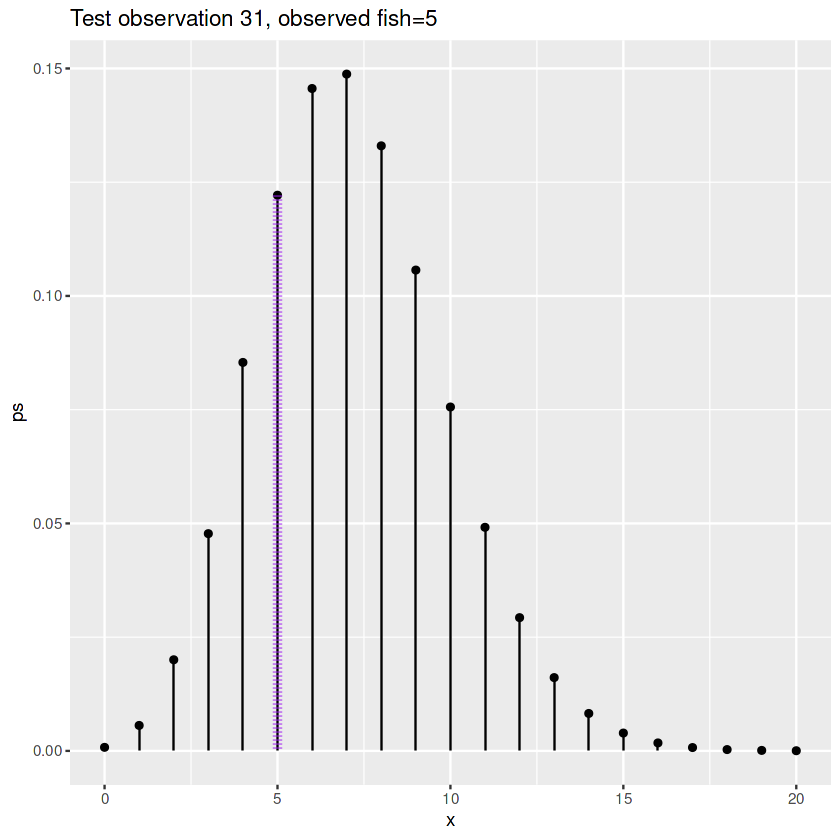

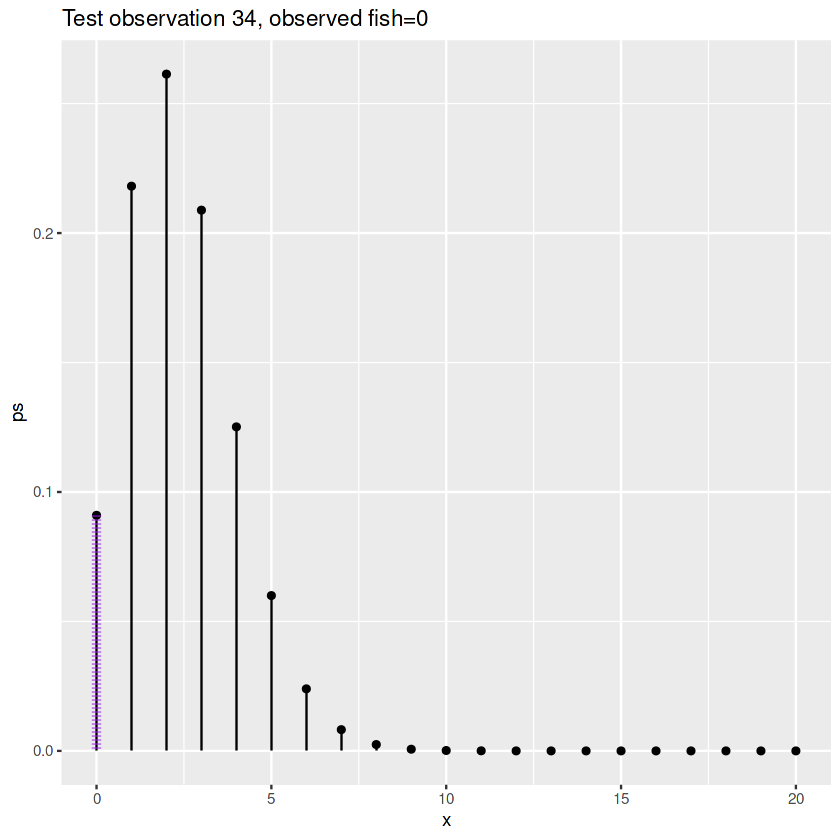

In [19]:
make_plot = function(obs){
df = data.frame(
    x = 0:20,
    y = y_test[obs],
    ps = exp(as.numeric(model_p(X_test[obs,,drop=FALSE])$log_prob(0:20)))
)
df2 = data.frame(y = df$ps[df$x==y_test[obs]], x=y_test[obs])
p = ggplot(df, aes(x=x, y=ps, xend=x, yend=0)) + 
    geom_point() + geom_segment() + 
    geom_segment(data=df2, aes(x=x, xend=x, y=y, yend=0), 
                 color="purple", linetype="dotted", size=2) + 
    ggtitle(sprintf("Test observation %i, observed fish=%i", obs, y_test[obs]))
return (p)
}
make_plot(31)
make_plot(34)